# Data Wrangling


# 1. Data Set Variables

The data set is provided by Kaggle. The data is loaded in to Pandas data frame without difficulty. 

In order to understand our data, we should look at each variable and try to understand their meaning and relevance to this problem. The detail description of each variabl can be found in provided "data_description.txt". We can create a spreadsheet with the following columns:
* <b>Variable</b> - Variable name.
* <b>Type</b> - Identification of the variables' type. There are two possible values for this field: 'numerical' or 'categorical'. 
* <b>Expectation</b> - Our expectation about the variable influence in 'SalePrice'. We can use a categorical scale with 'High', 'Medium' and 'Low' as possible values.
* <b>Conclusion</b> - Our conclusions about the importance of the variable, after we give a quick look at the data. We can keep with the same categorical scale as in 'Expectation'.
* <b>Comments</b> - Any general comments that occurred to us.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
#loan training data
df_train = pd.read_csv('../input/train.csv')

In [5]:
#check Variable
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# 2. Missing data

Missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. We need to check prevalent of missing data and if missing data is random or have a pattern.

In [6]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


If more than 15% of the data is missing, we should exclude the corresponding variable in our analysis. Variables 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage' will be excluded. 

'GarageCond', 'GarageType', 'GarageYrBlt', 'GarageFinish' and 'GarageQual' have the same percentage of missing data. These should be for the same set of obervation.  Since the number of car space is the most important factor for garage, we will take 'GarageCars' into our analysis and exclude the other Garage* with missing data.

'MasVnrArea' 'MasVnrType', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond' and 'BsmtQualwe' are not essential variabls. Furthermore, they have a strong correlation with 'YearBuilt', which we will consider. Thus, we will not lose information if we exclude these.

Finally, we have one missing observation in 'Electrical'. We'll delete this observation and keep the variable.

In summary, to handle missing data, we'll delete all the variables with missing data, except the variable 'Electrical'. In 'Electrical' we'll just delete the observation with missing data.

In [7]:
#handling with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max()

0

In [8]:
type(total)

pandas.core.series.Series

# 3. Outliers

Outliers can markedly affect our models and can be a valuable source of information, providing us insights about specific behaviors. We'll just do a quick analysis through the standard deviation of 'SalePrice' and a set of scatter plots.

### 3.1 Univariate analysis

The primary concern here is to establish a threshold that defines an observation as an outlier. To do so, we'll standardize the sale price data by converting data values to have mean of 0 and a standard deviation of 1.

In [9]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:5]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-5:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]]

outer range (high) of the distribution:
[[5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


Low range values are similar and not too far from 0. High range values are far from 0 and two values larger than 7 are really out of range. For now, we'll not consider any of these values as an outlier but we should be careful with those two values larger than 7.

### 3.2 Bivariate analysis

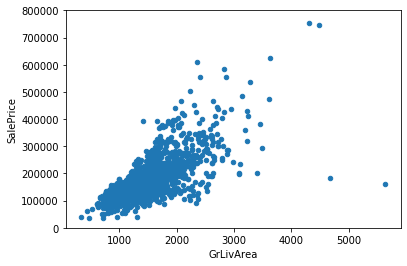

In [10]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

The two values with bigger 'GrLivArea' seem strange and they are not following the crowd. Therefore, we'll define them as outliers and delete them.
The two observations in the top of the plot look like two special cases, however they seem to be following the trend. We will keep them.

In [11]:
#deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

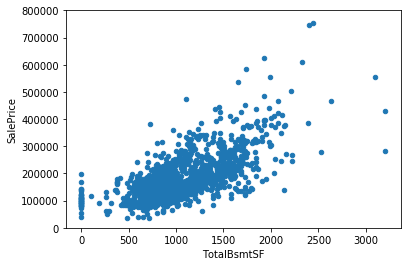

In [12]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

The ones with TotalBsmtSF > 3000 look like outliers. But we can keep them for now.

# Data Story


Sales price descriptive statistics summary

In [13]:
df_train['SalePrice'].describe()

count      1457.000000
mean     180942.138641
std       79521.569966
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [14]:
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.880363
Kurtosis: 6.516048


The price is right Skewed. Distributions with kurtosis greater than 3 are said to be leptokurtic

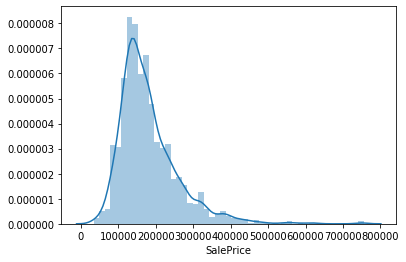

In [13]:
#histogram
sns.distplot(df_train['SalePrice']);


The histogram above shows an overview of the corresponding data set. The lowest sale price of a house is 34, 900 and the highest price is 755, 000. Majority of the sale prices are towards the cheaper side, with an average sale price of 180, 921. There are only a few sales prices that are over 500, 000. 

   SalePrice  YearBuilt
0     208500       2003
1     181500       1976
2     223500       2001
3     140000       1915
4     250000       2000


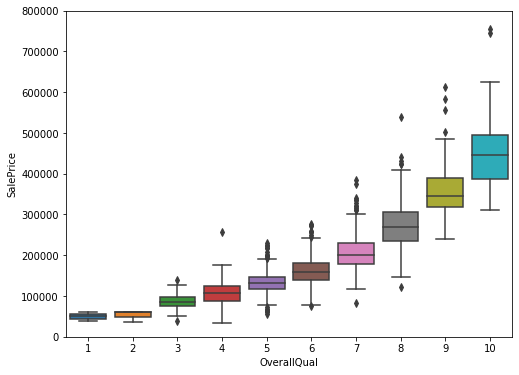

In [40]:
# Relationship with categorical features
#box plot overallqual/saleprice
var = 'OverallQual'
#data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
print(data.head())
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=df_train)
fig.axis(ymin=0, ymax=800000);


The box plot above shows a plot of the individual sale price of a house versus the overall quality of each house. The gray horizontal line in each box plot represents the average sale price for each overall quality. On average, as the overall quality increases the sale price increases with it. 

In [18]:
data.head()

,SalePrice,OverallQual
0,208500,7
1,181500,6
2,223500,7
3,140000,7
4,250000,8


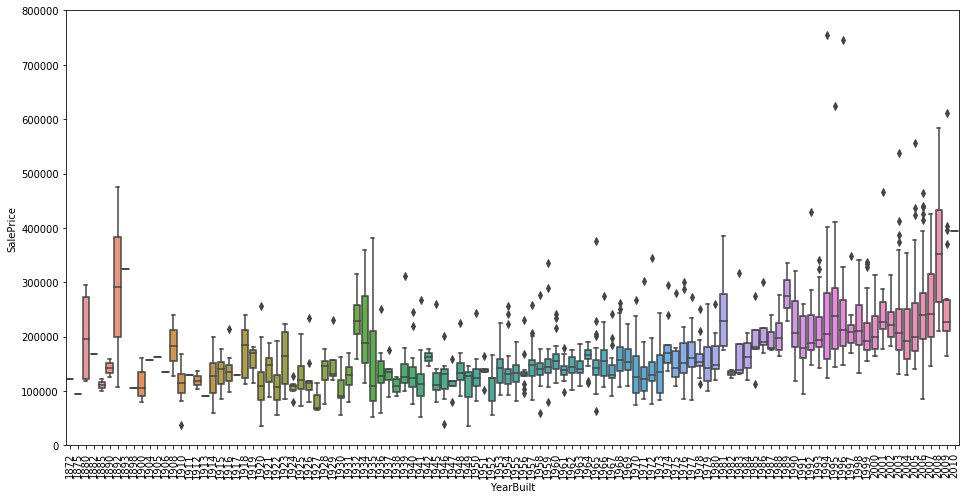

In [41]:
plt.rc('xtick', labelsize=10)
var = 'YearBuilt'
#data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=df_train)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

In summary
Stories aside, we can conclude that:
'GrLivArea' and 'TotalBsmtSF' seem to be linearly related with 'SalePrice'. Both relationships are positive, which means that as one variable increases, the other also increases. In the case of 'TotalBsmtSF', we can see that the slope of the linear relationship is particularly high.
'OverallQual' and 'YearBuilt' also seem to be related with 'SalePrice'. The relationship seems to be stronger in the case of 'OverallQual', where the box plot shows how sales prices increase with the overall quality.
We just analysed four variables, but there are many other that we should analyse. The trick here seems to be the choice of the right features (feature selection) and not the definition of complex relationships between them (feature engineering).

To explore the data, we will start with Correlation matrix,'SalePrice' correlation matrix, Scatter plots between the most correlated variables

In [ ]:
#### Correlation matrix (heatmap style)

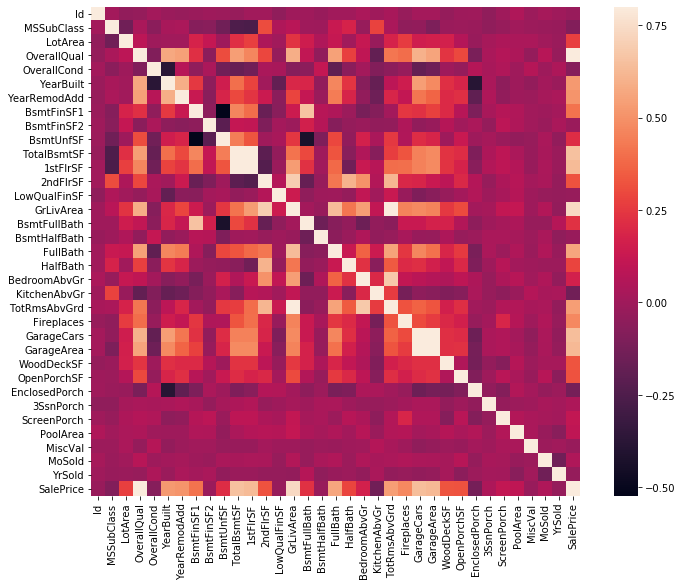

In [15]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

This heatmap is a good way to get a quick overview.

At first sight, there are two red colored squares that get my attention. The first one refers to the 'TotalBsmtSF' and '1stFlrSF' variables, and the second one refers to the 'Garage*X*' variables. Both cases show how significant the correlation is between these variables. Actually, this correlation is so strong that it can indicate a situation of multicollinearity. If we think about these variables, we can conclude that they give almost the same information so multicollinearity really occurs. Heatmaps are great to detect this kind of situations and in problems dominated by feature selection, like ours, they are an essential tool.

Another thing that got my attention was the 'SalePrice' correlations. We can see our well-known 'GrLivArea', 'TotalBsmtSF', and 'OverallQual' , but we can also see many other variables that should be taken into account. 

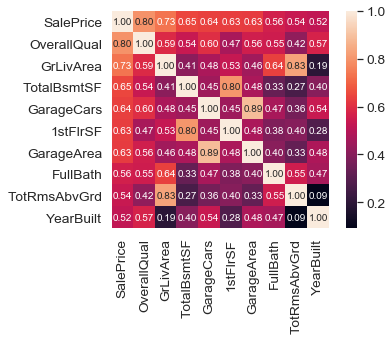

In [42]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

These are the variables most correlated with 'SalePrice':

* 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'. 
* 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However, as we discussed in the last sub-point, the number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers. You'll never be able to distinguish them. Therefore, we just need one of these variables in our analysis and we can keep 'GarageCars' since its correlation with 'SalePrice' is higher.
* 'TotalBsmtSF' and '1stFloor' also seem to be twin brothers. We can keep 'TotalBsmtSF'.
* 'FullBath'
* 'TotRmsAbvGrd' and 'GrLivArea', twin brothers again.
* 'YearBuilt' is slightly correlated with 'SalePrice'.

Let's proceed to the scatter plots.

Scatter plots between 'SalePrice' and correlated variables 

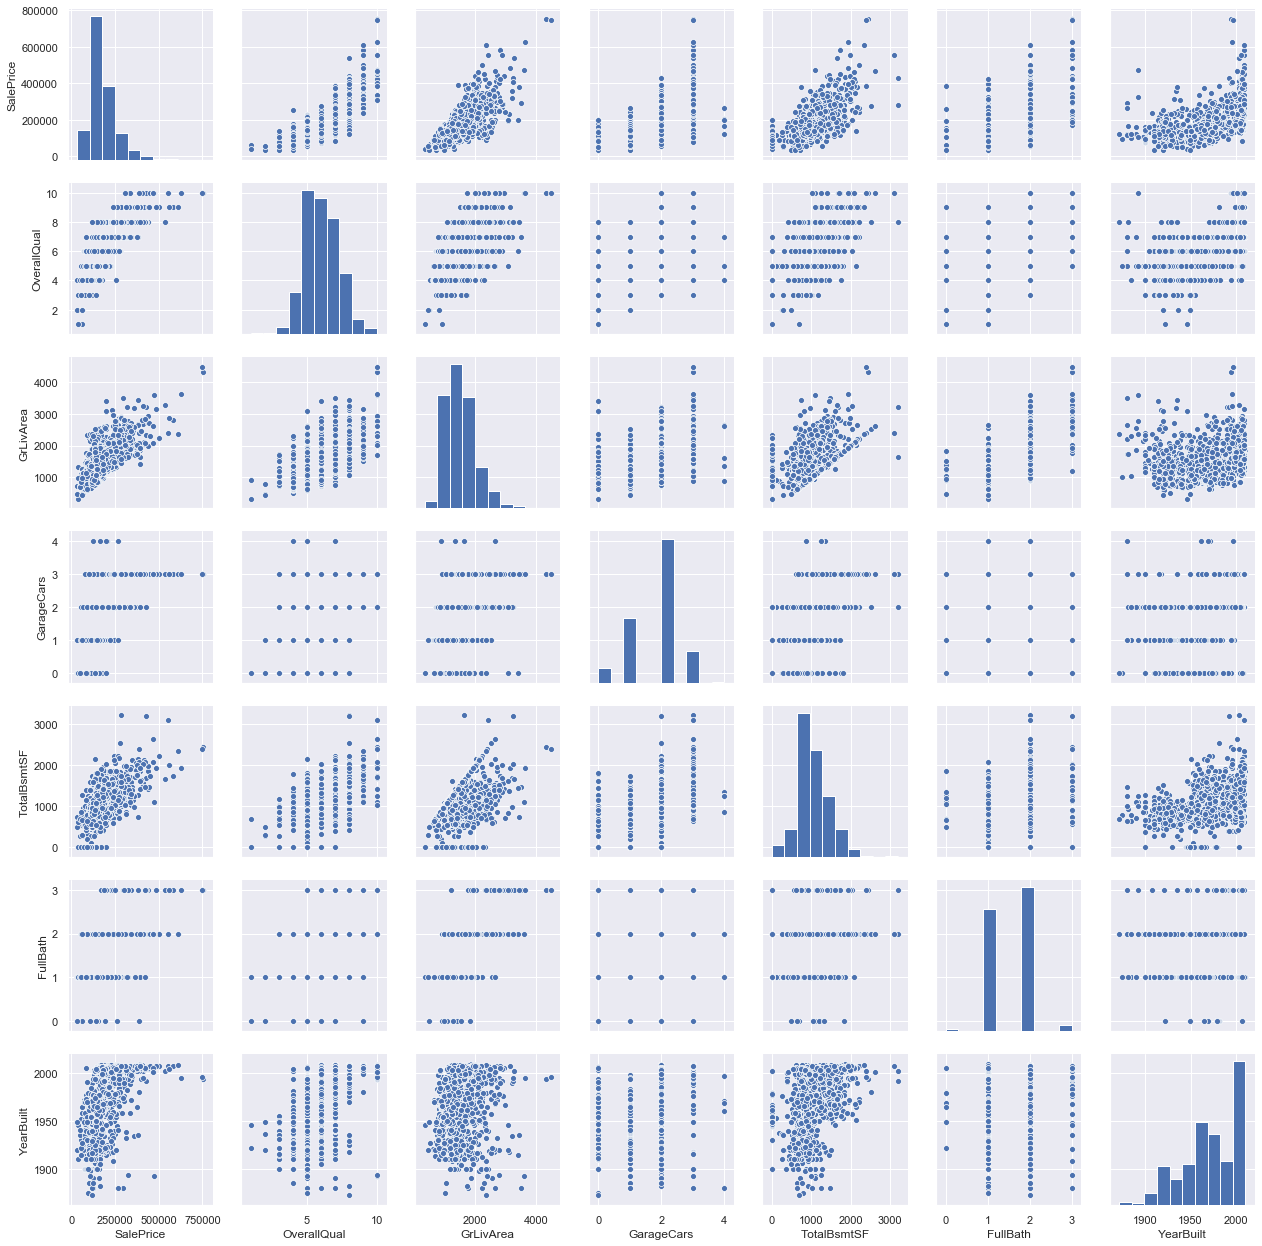

In [43]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'FullBath','TotalBsmtSF',  'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

The pairplot above shows correlation between the sale price of each house, the overall quality (OverallQual), above grade living area in square feet (GrLivArea), total square feet of basement area (TotalBsmtSF), full bathrooms above grade (FullBath) and the original construction date (YearBuilt). In the first row it shows the correlation of the sales price towards the other features. Visually there is a linear increase between each feature and the sales price. Several graphs in the pairplot above show linear relationships. 

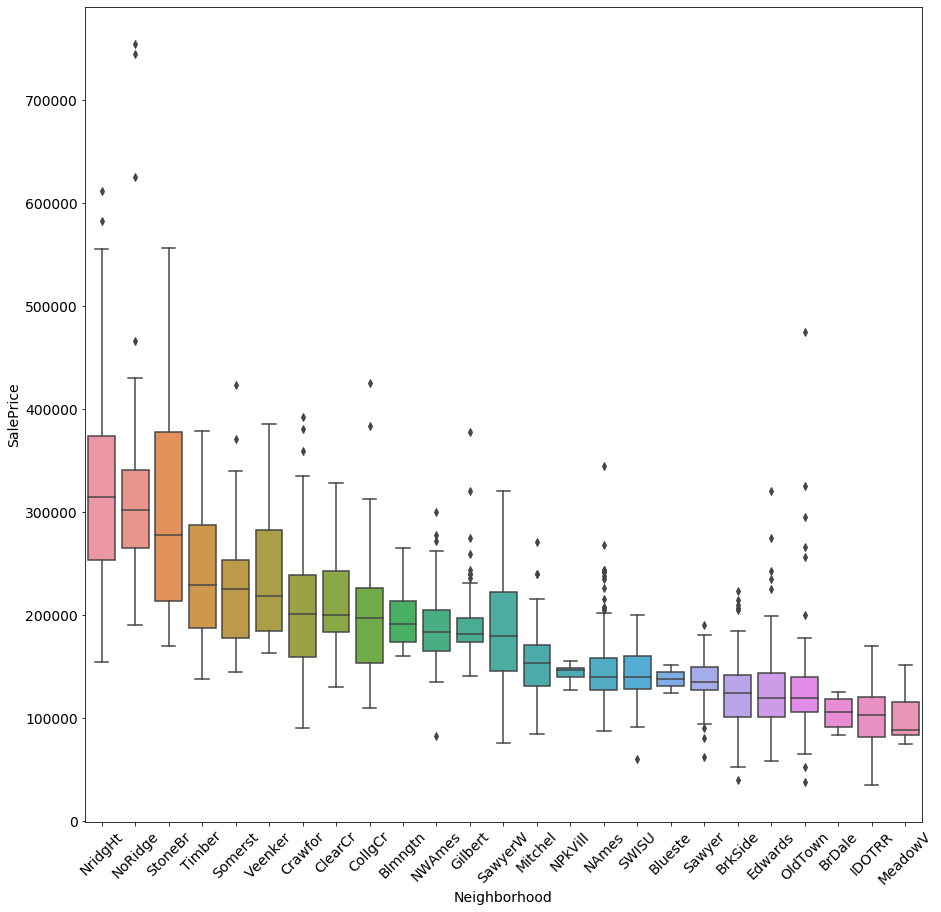

In [16]:
plt.figure(figsize= (15,15))
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Neighborhood',fontsize=14)
plt.ylabel('SalePrice',fontsize=14)
my_order = df_train.groupby(by=["Neighborhood"])["SalePrice"].median().sort_values(ascending=False).index
ax = sns.boxplot(x="Neighborhood", y="SalePrice", data=df_train, order=my_order)


The above box plot graph shows the sales prices for each of the neighborhoods in the given data. The neighborhood NridgHt has the highest average sales price. That said, the neighborhood NoRidge has three of the most expensive homes. 